# Predicting Which Customers Are Most Likely to Close Bank Account

This notebook explores the use of Python-based machine learning and data to build a predictive model for customer churn in a bank.

We will be following this approach:


## 1. Problem Definition

Goliath National Bank has noticed quite a few customers have moved to other banks. The bank is interested to see if there are any patterns in common with former customers to help identify customers most likely to leave the bank so the customer retention department can reach out preemptively.

## 2. [Data](#data)
Kaggle (https://www.kaggle.com/datasets/bhuviranga/customer-churn-data).

Data Dictionary:

* Customer ID: a unique identifier for each customer
* Credit Score: the higher the credit score, the better the customer has been with managing credit and debt
* State: the state on the customer's account
* Sex: Male or Female
* Age: Age of the customer
* Tenure: How many years the customer has been with the bank
* Balance: Current balance or balance at the time the customer closed their account
* Products_Number: The number of products (checking, savings, CDs, etc.) the customer has with the bank.
* Credit_Card: Does the customer have a credit card with the bank? 1 = Yes, 0 = No
* Active_Member: 1 = Yes, 0 = No
* Estimated_Salary: Estimated salary of the customer
* Churn: 1 = Yes (no longer a customer) 0 = No 

## 3. [Evaluation](#analysis)
Goal is for 85% prediction

## 4. [Predictive Features](#predictive-features)





#### Setting Up the Tools

We'll be utilizing Pandas, Matplotlib, and NumPy for the analysis and manipulation of our data and ipywidgets for prediction

In [217]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display plots inside the notebook
%matplotlib inline

# Import tools for machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Import tools for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore')

# Import ipywidgets to use for interactive features
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

<a id='data'></a>
## 2. Data
### Load Data

In [165]:
# Reading the CSV file on Github
# rubric: collected or available datasets
url = 'https://raw.githubusercontent.com/Gracej83/Datafile/main/BankCustomerChurnPredictionRevised.csv'
df = pd.read_csv(url, index_col='customer_id')

### Exploratory Data Analysis

Let's look at the the data and see if we notice any patterns on our own.

In [166]:
# Display first five rows to see that data imported properly
df.head()

,credit_score,state,sex,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,,,,,,,,,,,
15634602,619,New Jersey,Female,42,2,0.00,1,1,1,101348.88,1
15647311,608,Pennsylvania,Female,41,1,83807.86,1,0,1,112542.58,0
15619304,502,New Jersey,Female,42,8,159660.80,3,1,0,113931.57,1
15701354,699,New Jersey,Female,39,1,0.00,2,0,0,93826.63,0
15737888,850,Pennsylvania,Female,43,2,125510.82,1,1,1,79084.10,0


In [167]:
# Count the churn column to see how many have left (1) and how many remain (0)
df["churn"].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

In [168]:
# Check data for null values
df.isnull().sum()

credit_score        0
state               0
sex                 0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [169]:
# rubric: ability to support featurizing, parsing, cleaning, and wrangling datasets
# Convert sex and state to numbers a dictionary
encoder = {"sex": {"Male": 0, "Female": 1}, "state": {"New York": 0, "New Jersey": 1, "Pennsylvania": 2}}
encoded_df = df.replace(encoder)

# compare above and see that the state and sex converted correctly
encoded_df.head()

,credit_score,state,sex,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,,,,,,,,,,,
15634602,619,1,1,42,2,0.00,1,1,1,101348.88,1
15647311,608,2,1,41,1,83807.86,1,0,1,112542.58,0
15619304,502,1,1,42,8,159660.80,3,1,0,113931.57,1
15701354,699,1,1,39,1,0.00,2,0,0,93826.63,0
15737888,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [170]:
# Get statistics on the data
encoded_df.describe()

,credit_score,state,sex,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.996800,0.454300,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.706144,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,1.000000,0.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [171]:
# Display the percentage distribution
churn_percentage = encoded_df["churn"].value_counts(normalize=True) * 100
print("Churn Percentage:\n", churn_percentage)

Churn Percentage:
 churn
0    79.63
1    20.37
Name: proportion, dtype: float64


# Descriptive 

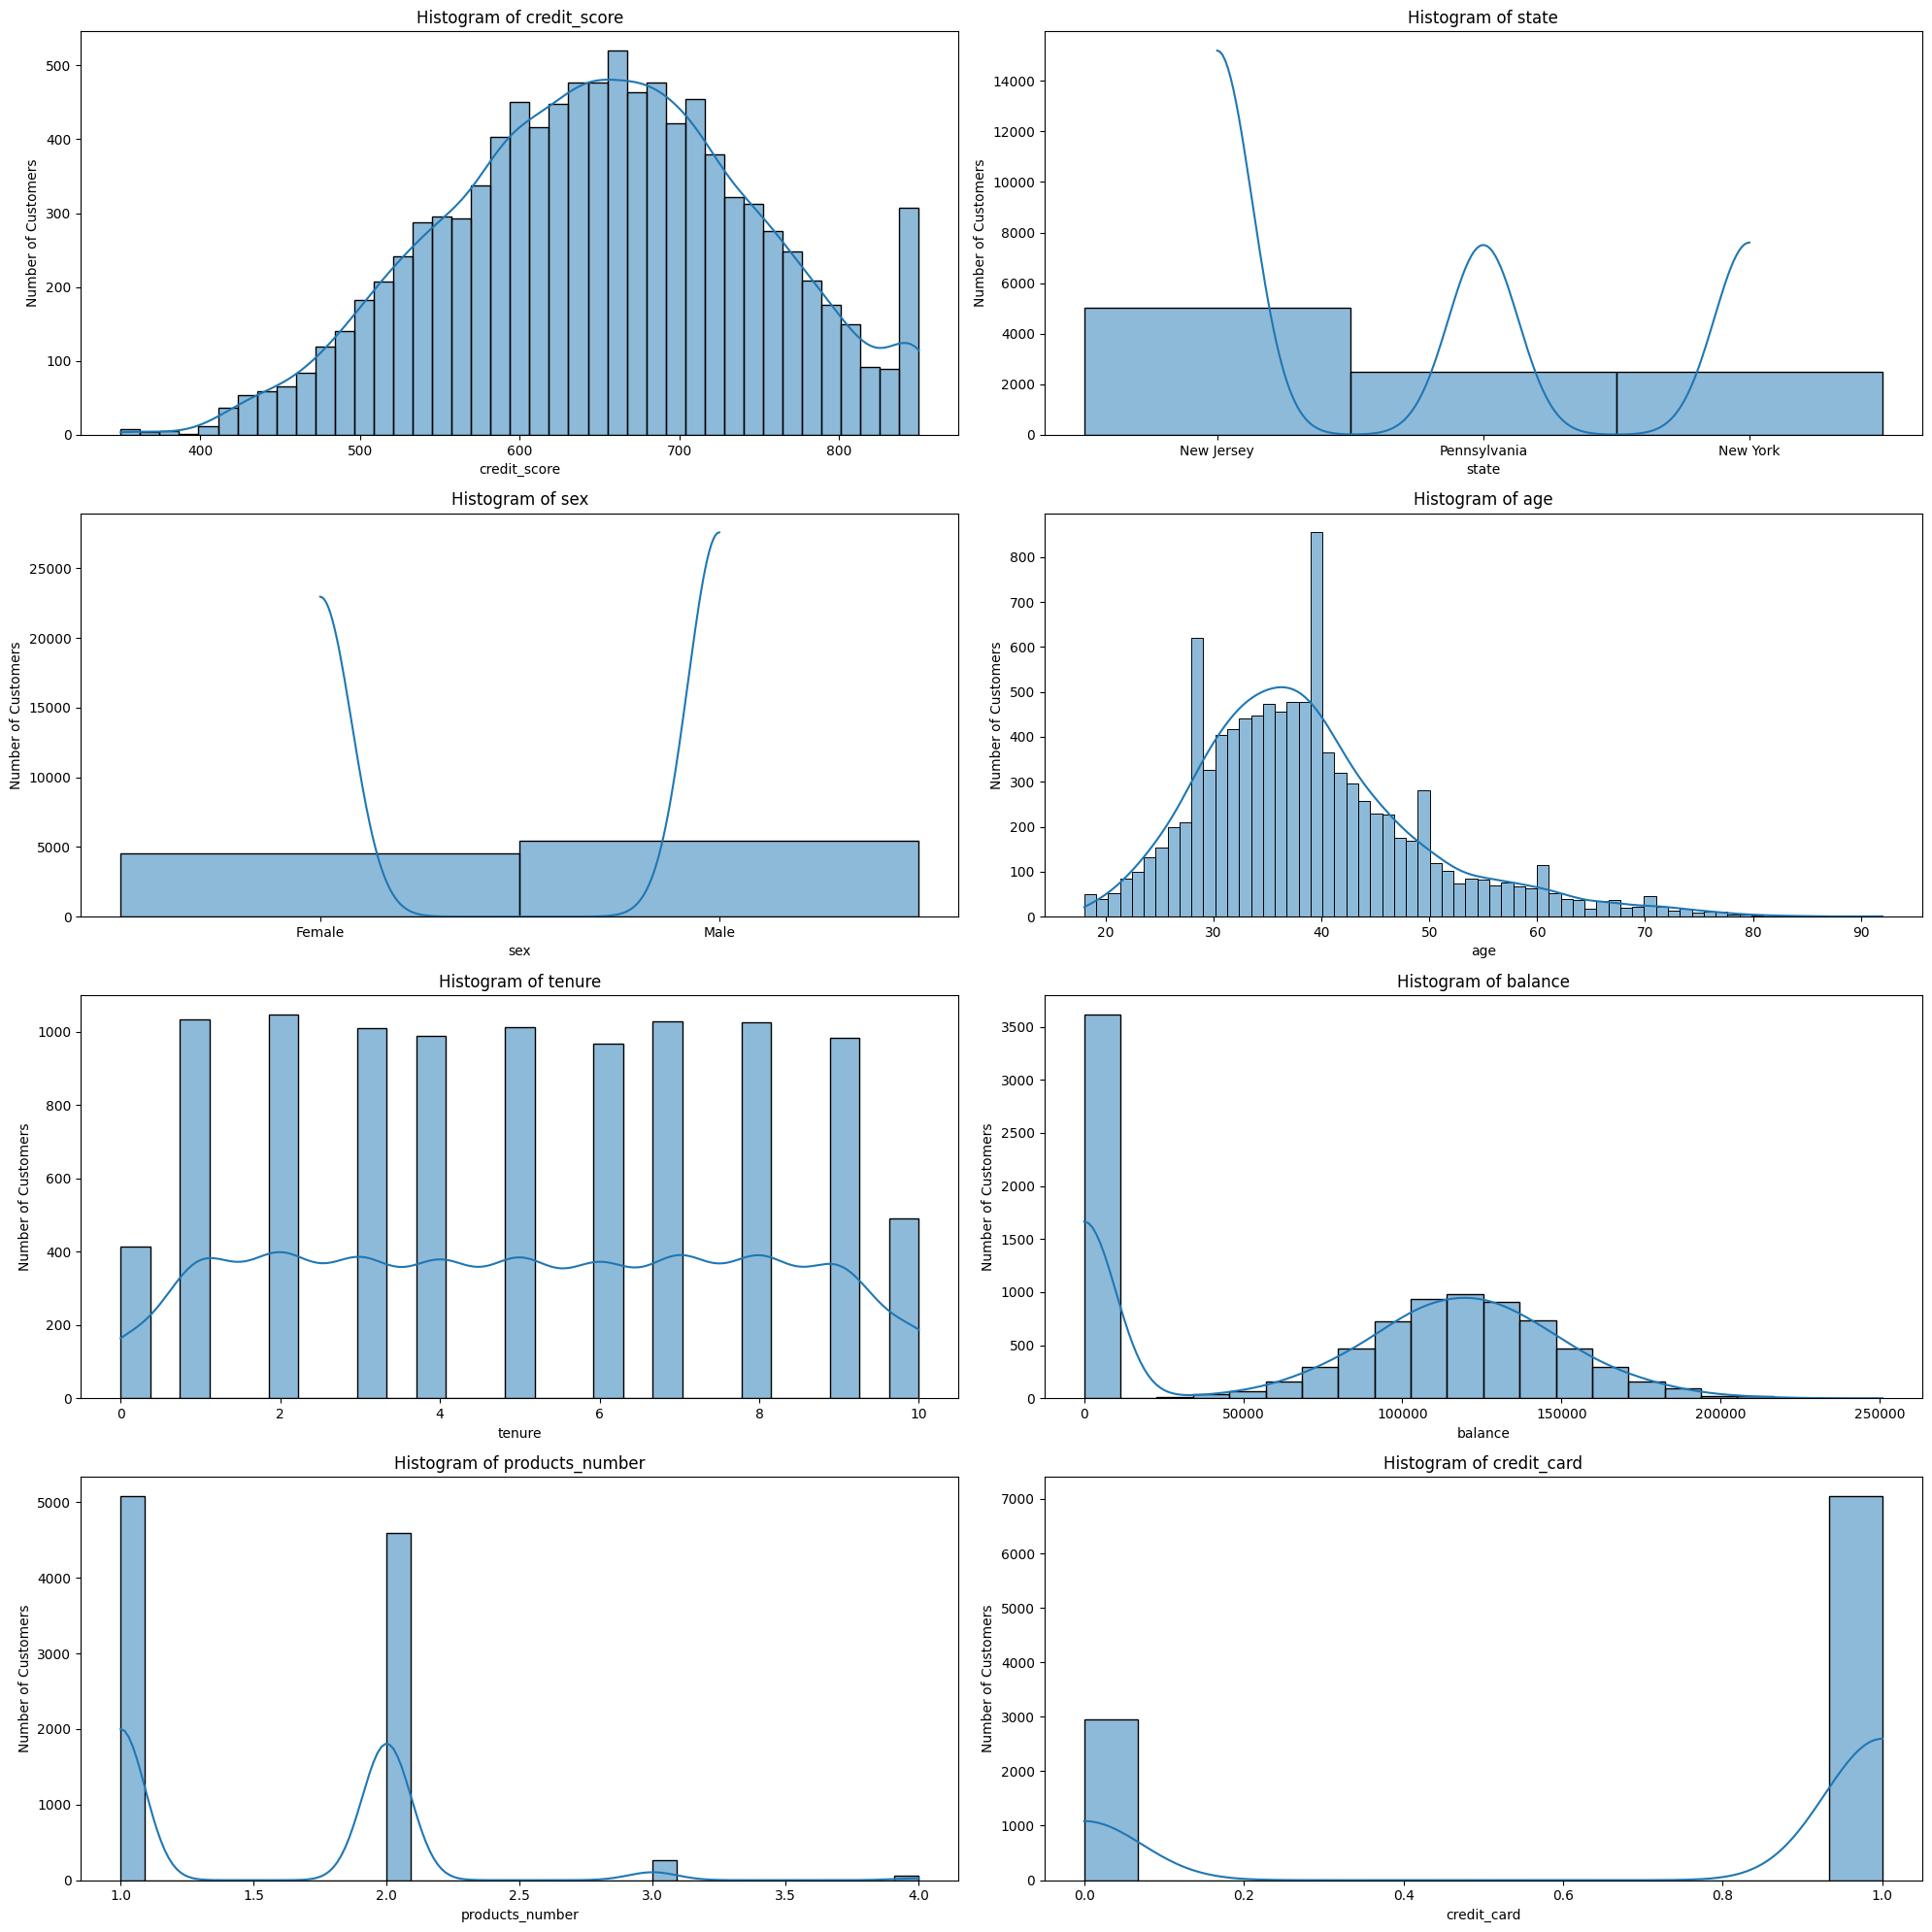

In [172]:
# rubric: a user-friendly, functional dashboard that includes three visualization types
# rubric: one descriptive method
# rubric: data visualization functionalities for data exploration and inspection
# Look at histograms to see the distribution of data
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
axes = axes.flatten()

for ax, col in zip(axes, encoded_df.columns):
    sns.histplot(df[col], ax=ax, kde=True)  

    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

<Axes: >

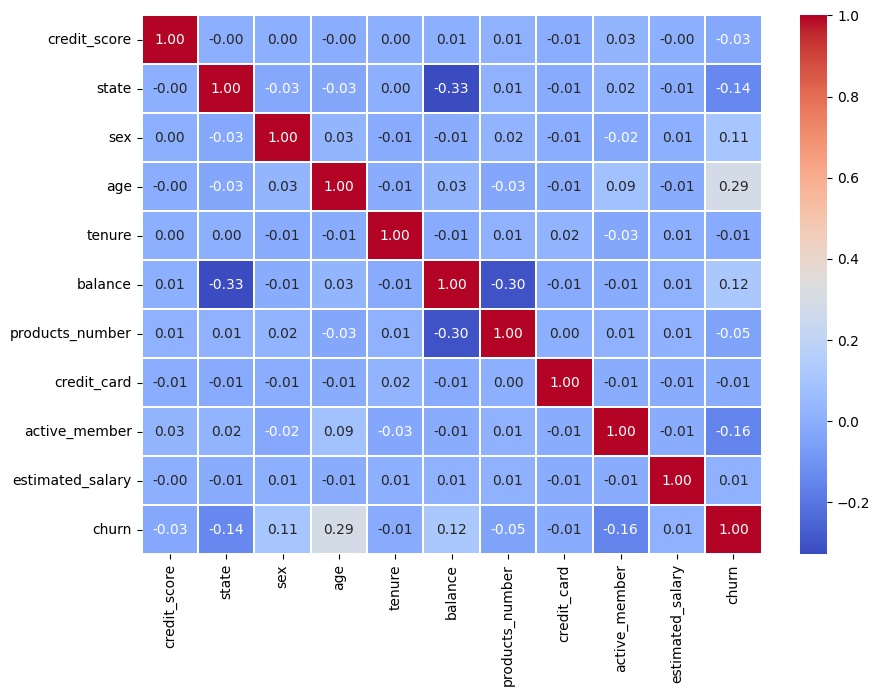

In [173]:
# Correlation matrix if there is a variance between churned customers. 
correlation_matrix= encoded_df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.1, fmt='.2f')

We can see that the strongest correlation with churn we have is age with 0.29. So let's break up the age into buckets. We know from above that the age column ranges from 18 to 92 with a mean of 38.92 and a standard deviation of 10.48. Let's break the customers into buckets of 10 years with 18-19 year olds grouped with the 20 year olds.

In [174]:
# ability to support featurizing, parsing, cleaning, and wrangling datasets
age_bins = [17,28,38,48,58,68,78,88,98]
age_labels = [20,30,40,50,60,70,80,90]

df_age_grouped = encoded_df.copy()
df_age_grouped['age_group'] = pd.cut(encoded_df['age'], bins=age_bins, labels=age_labels)

# make sure age_group is numeric
df_age_grouped['age_group'] = pd.to_numeric(df_age_grouped['age_group']).astype('Int64')

# print to see if it worked.
df_age_grouped.head(10)


,credit_score,state,sex,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_group
customer_id,,,,,,,,,,,,
15634602,619,1,1,42,2,0.00,1,1,1,101348.88,1,40
15647311,608,2,1,41,1,83807.86,1,0,1,112542.58,0,40
15619304,502,1,1,42,8,159660.80,3,1,0,113931.57,1,40
15701354,699,1,1,39,1,0.00,2,0,0,93826.63,0,40
15737888,850,2,1,43,2,125510.82,1,1,1,79084.10,0,40
15574012,645,2,0,44,8,113755.78,2,1,0,149756.71,1,40
15592531,822,1,0,50,7,0.00,2,1,1,10062.80,0,50
15656148,376,0,1,29,4,115046.74,4,1,0,119346.88,1,30
15792365,501,1,0,44,4,142051.07,2,0,1,74940.50,0,40


In [175]:
# Look to see what percent of each age group left or stayed
grouped = df_age_grouped.groupby('age_group')['churn'].agg(Count='value_counts')

dfgp = grouped.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(), 2))
dfgp.rename(columns={'Count': 'Percentage'}, inplace=True)
dfgp = dfgp.pivot_table(values='Percentage', index='age_group', columns=['churn']).fillna(0)
dfgp


churn,0,1
age_group,,
20,92.58,7.42
30,89.96,10.04
40,72.25,27.75
50,44.23,55.77
60,61.45,38.55
70,89.61,10.39
80,94.12,5.88
90,100.00,0.00


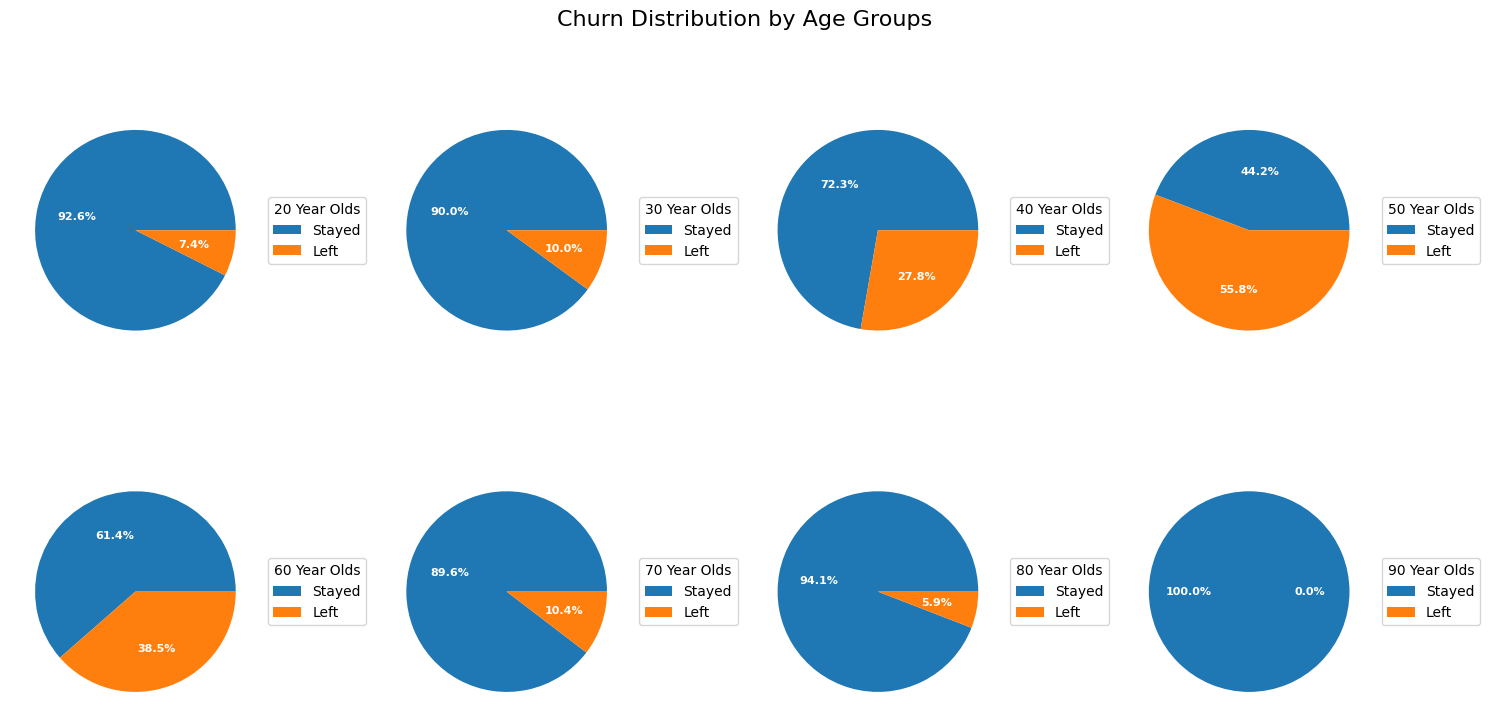

In [176]:
# rubric: a user-friendly, functional dashboard that includes three visualization types
# Let's look at pie charts showing what percent of customers churned by age group.
num_rows = 2  
num_cols = len(dfgp.index) // num_rows

# Plotting subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8), subplot_kw=dict(aspect="equal"))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through age groups and plot pie charts
for ax, age_group in zip(axes, dfgp.index):
    data = dfgp.loc[age_group]
    wedges, texts, autotexts = ax.pie(data, autopct='%1.1f%%', textprops=dict(color="w"))

    # Customize legend labels
    legend_labels = ['Stayed', 'Left']
    ax.legend(wedges, labels=legend_labels, title=f"{age_group} Year Olds", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

# Title for the entire plot
plt.suptitle("Churn Distribution by Age Groups", fontsize=16)

plt.tight_layout()
plt.show()

In [177]:
# Let's look to see if product number is correlated
grouped = df_age_grouped.groupby('products_number')['churn'].agg(Count='value_counts')

dfgp = grouped.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(), 2))
dfgp.rename(columns={'Count': 'Percentage'}, inplace=True)
dfgp = dfgp.pivot_table(values='Percentage', index='products_number', columns=['churn']).fillna(0)
dfgp

churn,0,1
products_number,,
1,72.29,27.71
2,92.42,7.58
3,17.29,82.71
4,0.00,100.00


We can see a pretty high percentage of customers with 3 or 4 products left.

<a id='analysis'></a>
## 3. Evaluation

Now let us use the tools to break the data to test and train to and then perform analysis on the data

In [178]:

# Using the dataframe with sex and state represented with numbers. Breaking the data into X and Y axis
X=encoded_df.drop(['churn'],axis=1)
y=encoded_df['churn']
scaler=StandardScaler()


In [179]:
# Use test-train-split to separate the data for training and testing
# using 30% test group size and stratify = y to keep proportions similar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [180]:
# Look at how many in the train set. Should be 70%
len(X_train)

7000

In [181]:
# Look at how many in test set. Should be 30%
len(X_test)

3000


There are a few types of analysis that we will use to determine which one is the most accurate with this data:

1 [Random Forest](#Random-Forest)

2 [Logistic Regression](#Logistic-Regression)

3 [K Nearest Neighbor](#K-Nearest-Neighbor)
 

<a id='Random_Forest'></a>
#### Random Forest


In [182]:
# rubric: methods and algorithms supporting data exploration and preparation
param_grid = {
    'n_estimators': [50, 100, 150], # number of trees in forest
    'max_depth': [None , 10, 20], # maximum depth of a tree
    'min_samples_split': [2, 5, 10], # minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4], # minimum samples to be at a leaf node
}

In [183]:
# run random forest classifier
rfc=RandomForestClassifier()
# run grid search to determine best parameters
rf_Grid=GridSearchCV(estimator=rfc,param_grid=param_grid,cv=3,verbose=0,n_jobs=-1,return_train_score=False)

In [184]:
# this takes about 30 seconds to run
rf_Grid.fit(X_train,y_train)
rf_Grid.best_params_

{'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 150}

In [185]:
# rerun Random Forest with best parametes found with GridSearchCV
rf=RandomForestClassifier(**rf_Grid.best_params_)

In [186]:
rf.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=150)

In [187]:
# Accuracy score
y_pred1=rf.predict(X_test)
score_rf=accuracy_score(y_test,y_pred1)
score_rf

0.8606666666666667

In [188]:
# calculate f1 score which is the harmonic mean between precision and recall. 
# It ranges between 0 and 1, higher is better.
f1_rf=f1_score(y_pred1,y_test)
f1_rf

0.5769230769230769

In [189]:
# generate confusion matrix to show how often the model was correct
cm = metrics.confusion_matrix(y_test, y_pred1)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.76      0.47      0.58       611

    accuracy                           0.86      3000
   macro avg       0.82      0.71      0.75      3000
weighted avg       0.85      0.86      0.85      3000



Text(50.722222222222214, 0.5, 'True')

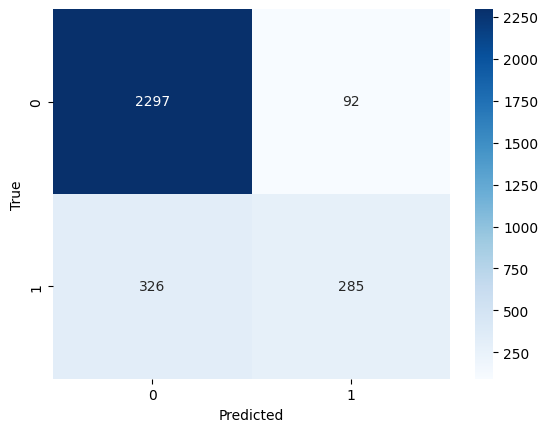

In [190]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

So the model is very good at predicting which customers will stay but not which customers will leave. It only had 82 false positives, but had 348 false negatives. 

<a id='Logistic-Regression'></a>
#### Logistic Regression

In [220]:
# run logistic regression without any paramters
lgr=LogisticRegression()

In [221]:
# create parameter grid with common parameters to use in the grid search
param_grid = {
    'penalty': ['l1','l2'], # L1 and L2 are types of regularization
    'solver' :['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'], # solvers are algos for optimization
    'max_iter': [1000,1500,2000], # maximum number of iterations
    'multi_class' :['auto', 'ovr', 'multinomial'], # ovr is One vs Rest. multinomial is for multi-class problems
    'class_weight' :['dict','balanced'] # handles imbalances between classes
}

In [222]:
# run GridSearchCV to look for optimal parameters
lgr_grid=GridSearchCV(estimator=lgr,param_grid=param_grid,cv=3,verbose=0,n_jobs=-1,return_train_score=True)

In [223]:
lgr_grid.fit(X_train,y_train)
lgr_grid.best_params_

{'class_weight': 'balanced',
 'max_iter': 1000,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [224]:
# rerun Logistic Regression with best parameters
log=LogisticRegression(**lgr_grid.best_params_)

In [225]:
log.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [226]:
# calculate prediction score
y_pred2=log.predict(X_test)
score_log=accuracy_score(y_test,y_pred2)
score_log

0.6986666666666667

In [227]:
# calculate F1
f1_log=f1_score(y_pred2,y_test)
f1_log

0.4786620530565167

In [228]:
# generate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred2)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      2389
           1       0.37      0.68      0.48       611

    accuracy                           0.70      3000
   macro avg       0.63      0.69      0.63      3000
weighted avg       0.79      0.70      0.73      3000



Text(50.722222222222214, 0.5, 'True')

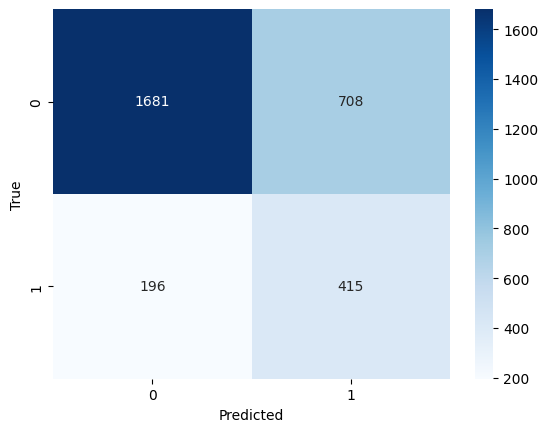

In [200]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

This model has much higher false positives than Random Forest but also had much higher true negatives.
Let's see if KNN is any better.

<a id='K-Nearest-Neighbor'></a>
#### K Nearest Neighbor

In [201]:
param_grid = [{
    'n_neighbors': range(3,21),
    'algorithm':['ball_tree','kd_tree','brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}]

In [202]:
#Run grid search CV to find optimal parameters
knn_Grid= GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=3, verbose=0, n_jobs=-1)

In [203]:
# takes almost 30 seconds
knn_Grid.fit(X_train,y_train)
knn_Grid.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

In [204]:
knn=KNeighborsClassifier(**knn_Grid.best_params_)

In [205]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=20, p=1,
                     weights='distance')

In [206]:
y_pred3=knn.predict(X_test)
score_knn=accuracy_score(y_pred3,y_test)
score_knn

0.8346666666666667

In [207]:
f1_knn=f1_score(y_pred3,y_test)
f1_knn

0.42592592592592593

In [208]:
cm = metrics.confusion_matrix(y_test, y_pred3)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2389
           1       0.73      0.30      0.43       611

    accuracy                           0.83      3000
   macro avg       0.79      0.64      0.66      3000
weighted avg       0.82      0.83      0.81      3000



Text(50.722222222222214, 0.5, 'True')

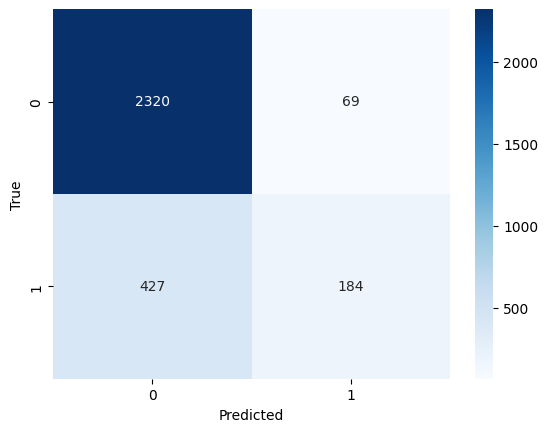

In [209]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

In [210]:
# Let's compare the models by the numbers
print('ACCURACY')
print('Accuracy of Random Forest is',score_rf)
print('Accuracy of Logistic Regession is',score_log)
print('Accuracy of KNN is',score_knn)

ACCURACY
Accuracy of Random Forest is 0.8606666666666667
Accuracy of Logistic Regession is 0.6986666666666667
Accuracy of KNN is 0.8346666666666667


We can see Random Forest is the most accurate based on the test/train split

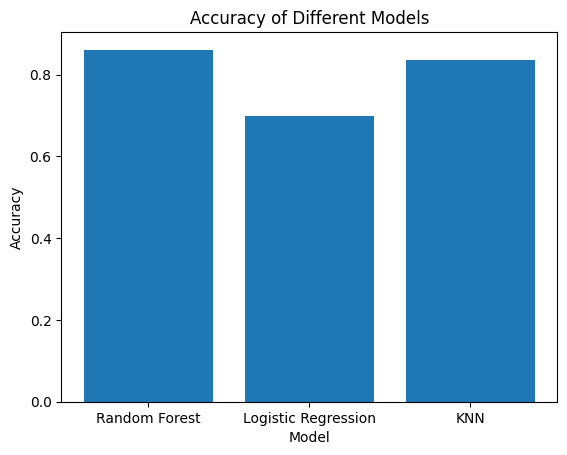

In [211]:
# Let's see this as a chart as well
models = ['Random Forest', 'Logistic Regression', 'KNN']
accuracies = [score_rf, score_log, score_knn]

# Plotting the bar chart
plt.bar(models, accuracies)

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')

# Display the plot
plt.show()

Conclusion:
Random Forest Classifier had the highest overall accuracy, but ultimately if Goliath National Bank is going to reach out to customers that takes human resources. If any promotions are offered, that comes at a cost if the customer accepts. False negatives mean more customers who weren't planning on leaving are contacted. False positives mean customers who did leave were not predicted. When comparing the numbers, Random Forest and KNN have fairly similar results in the confusion matrix. Logistic Regression had the lowest number of false negatives (191 compared to 348 and 427), but significantly more false positives (690 compared to 82 and 61).

After weighing the false positives and false negatives, Random Forest is the best fit.

<a id='predictive-features'></a>
## 4. Predictive Features
### Can we predict customers likely to churn?

credit_score, state, sex, age, tenure, balance, products_number, credit_card, active_member, estimated_salary

In [219]:
# Create sliders for credit score and age
credit_score_slider = widgets.IntSlider(description='Credit Score', min=300, max=850, value=500)
age_slider = widgets.IntSlider(description='Age', min=18, max=100, value=30)

# Create dropdown for state
state_dropdown = widgets.Dropdown(
    options={'NY': 0, 'NJ': 1, 'PA': 3},
    value=0,
    description='State:'
)

# Create radio buttons for sex
sex_radio_buttons = widgets.RadioButtons(
    options={'Male': 0, 'Female': 1},
    description='Sex:'
)

# Create text boxes
tenure_text = widgets.IntText(description='Tenure', value=0)
balance_text = widgets.FloatText(description='Balance', value=0.0)
products_text = widgets.IntText(description='Products', value=1)
credit_card_radio = widgets.RadioButtons(
    options={'Yes': 0, 'No': 1},
    description='Credit Card:'
)
active_member_radio = widgets.RadioButtons(
    options={'Yes': 0, 'No': 1},
    description='Active Member:'
)
salary_text = widgets.FloatText(description='Salary', value=50000.0)

# Display widgets
display(credit_score_slider, age_slider, state_dropdown, sex_radio_buttons,
        tenure_text, balance_text, products_text, credit_card_radio,
        active_member_radio, salary_text)

# Function to use the selected values
def create_array(credit_score, age, state, sex, tenure, balance, products, credit_card, active_member, salary):
    values_array = [credit_score, age, state, sex, tenure, balance, products, credit_card, active_member, salary]
    return np.array(values_array).reshape(1, -1)  # Reshape to match the model's input format

# Create a button to trigger the function
button = widgets.Button(description="Generate Array")

# Define an output widget to display the result
output = widgets.Output()

# Function to handle button click
def on_button_click(b):
    with output:
        clear_output(wait=True)
        input_array = create_array(
            credit_score_slider.value,
            age_slider.value,
            state_dropdown.value,
            sex_radio_buttons.value,
            tenure_text.value,
            balance_text.value,
            products_text.value,
            credit_card_radio.value,
            active_member_radio.value,
            salary_text.value
        )
        rf_prediction = rf.predict(input_array)
        if rf_prediction == 0:
            print("Random Forest Prediction: Customer will stay")
        else:
            print("Random Forest Prediction: Customer at risk of leaving")
        
        knn_prediction = knn.predict(input_array)
        if knn_prediction == 0:
            print("K Nearest Neighbor Prediction: Customer will stay")
        else:
            print("K Nearest Neighbor Prediction: Customer at risk of leaving")
        
        lr_prediction = log.predict(input_array)
        if lr_prediction == 0:
            print("Logistic Regression Prediction: Customer will stay")
        else:
            print("Logistic Regression Prediction: Customer at risk of leaving")

     

# Link the button click event to the handler function
button.on_click(on_button_click)

# Display the button
display(button)

# Display the output widget
display(output)


IntSlider(value=500, description='Credit Score', max=850, min=300)

IntSlider(value=30, description='Age', min=18)

Dropdown(description='State:', options={'NY': 0, 'NJ': 1, 'PA': 3}, value=0)

RadioButtons(description='Sex:', options={'Male': 0, 'Female': 1}, value=0)

IntText(value=0, description='Tenure')

FloatText(value=0.0, description='Balance')

IntText(value=1, description='Products')

RadioButtons(description='Credit Card:', options={'Yes': 0, 'No': 1}, value=0)

RadioButtons(description='Active Member:', options={'Yes': 0, 'No': 1}, value=0)

FloatText(value=50000.0, description='Salary')

Button(description='Generate Array', style=ButtonStyle())

Output()

After playing around with various settings on he model, the prediction mainly goes by how many products the customer has with all models agreeing that a customer with over four products is most likely to leave.
Logistic regression did have the highest negative predictions so it shows the customer is likely to leave more often than the other two models